## Importing Libraries

In [ ]:
#!pip install arbitragelab
!pip install yfinance

In [ ]:
pip install scikit-learn

In [4]:
#import arbitragelab as al
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import statsmodels.tsa.stattools as ts 

## Importing Data

In [5]:
# Get industry data from Wikipedia 
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
stock_table = table[0]
stock_table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [6]:
# Indutry groups to use are below
industry_group = ['Information Technology','Industrials','Financials','Health Care']

#Datarame with these industry group
ticker_industry = stock_table[stock_table['GICS Sector'].isin(industry_group)].reset_index(drop=True)
ticker_industry.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [7]:
# Dataframe to only contain symbol and sector
ticker_industry = ticker_industry[['Symbol', 'GICS Sector']]
ticker_industry.head()

,Symbol,GICS Sector
0,MMM,Industrials
1,AOS,Industrials
2,ABT,Health Care
3,ABBV,Health Care
4,ACN,Information Technology


In [8]:
# Get tickers to use as a list
tickers = ticker_industry['Symbol'].to_list()

# Removing some tickers
tickers = ticker_industry['Symbol'].to_list()
#remove_tickers = ['CARR','ABC','BRK.B','VNT','OTIS'] # Removed tickers
remove_tickers = ['AMTM', 'GEV', 'VLTO', 'SOLV', 'GEHC', 'BRK.B', 'NVDA'] # Removed tickers
tickers = [ticker for ticker in tickers if ticker not in remove_tickers]

# Get a dictionary of industry group
industry_dict = pd.Series(ticker_industry['GICS Sector'].values,index=ticker_industry['Symbol']).to_dict()
industry_dict

{'MMM': 'Industrials',
 'AOS': 'Industrials',
 'ABT': 'Health Care',
 'ABBV': 'Health Care',
 'ACN': 'Information Technology',
 'ADBE': 'Information Technology',
 'AMD': 'Information Technology',
 'AFL': 'Financials',
 'A': 'Health Care',
 'AKAM': 'Information Technology',
 'ALGN': 'Health Care',
 'ALLE': 'Industrials',
 'ALL': 'Financials',
 'AMTM': 'Industrials',
 'AXP': 'Financials',
 'AIG': 'Financials',
 'AMP': 'Financials',
 'AME': 'Industrials',
 'AMGN': 'Health Care',
 'APH': 'Information Technology',
 'ADI': 'Information Technology',
 'ANSS': 'Information Technology',
 'AON': 'Financials',
 'AAPL': 'Information Technology',
 'AMAT': 'Information Technology',
 'ACGL': 'Financials',
 'ANET': 'Information Technology',
 'AJG': 'Financials',
 'AIZ': 'Financials',
 'ADSK': 'Information Technology',
 'ADP': 'Industrials',
 'AXON': 'Industrials',
 'BAC': 'Financials',
 'BAX': 'Health Care',
 'BDX': 'Health Care',
 'BRK.B': 'Financials',
 'TECH': 'Health Care',
 'BIIB': 'Health Care',


In [9]:
# Loading data
train_data =  yf.download(tickers, start="2021-01-01", end="2022-01-01")
test_data =  yf.download(tickers, start="2022-01-02", end="2022-07-01")

[*********************100%***********************]  274 of 274 completed
[*********************100%***********************]  274 of 274 completed


## Processing Data

In [10]:
# Removing rows with null data
train_data.dropna()
test_data.dropna()

Price                       Adj Close                                      \
Ticker                              A        AAPL        ABBV         ABT   
Date                                                                        
2022-01-03 00:00:00+00:00  153.555573  179.273590  120.862564  131.440399   
2022-01-04 00:00:00+00:00  148.364456  176.998322  120.630501  128.349136   
2022-01-05 00:00:00+00:00  145.822845  172.290207  121.264168  127.772476   
2022-01-06 00:00:00+00:00  146.333145  169.414108  120.692986  127.753563   
2022-01-07 00:00:00+00:00  142.437317  169.581558  120.380608  128.150620   
...                               ...         ...         ...         ...   
2022-06-24 00:00:00+00:00  119.210114  139.913284  138.542099  104.246513   
2022-06-27 00:00:00+00:00  118.502457  139.913284  139.269638  103.894104   
2022-06-28 00:00:00+00:00  115.052658  135.745331  138.678543  101.884422   
2022-06-29 00:00:00+00:00  115.878242  137.513260  140.179092  103.913155   
2022-06-30 00:00:00+00:00  116.733322  135.034164  139.287842  103.484566   

Price                                                                     \
Ticker                          ACGL         ACN        ADBE         ADI   
Date                                                                       
2022-01-03 00:00:00+00:00  44.549999  389.190247  564.369995  168.473740   
2022-01-04 00:00:00+00:00  45.130001  386.408997  554.000000  166.952118   
2022-01-05 00:00:00+00:00  44.599998  379.604095  514.429993  164.374817   
2022-01-06 00:00:00+00:00  44.860001  361.272827  514.119995  164.897888   
2022-01-07 00:00:00+00:00  45.070000  354.343689  510.700012  160.570709   
...                              ...         ...         ...         ...   
2022-06-24 00:00:00+00:00  44.860001  287.718292  387.720001  143.719406   
2022-06-27 00:00:00+00:00  44.970001  281.231049  381.070007  144.583466   
2022-06-28 00:00:00+00:00  44.730000  272.754303  365.630005  142.567276   
2022-06-29 00:00:00+00:00  44.630001  268.919617  368.500000  141.395920   
2022-06-30 00:00:00+00:00  45.490002  266.843750  366.059998  140.263000   

Price                                              ...   Volume            \
Ticker                            ADP        ADSK  ...      WDC       WFC   
Date                                               ...                      
2022-01-03 00:00:00+00:00  230.287888  283.720001  ...  2947100  38978100   
2022-01-04 00:00:00+00:00  231.363785  278.190002  ...  3753000  43855100   
2022-01-05 00:00:00+00:00  229.391342  264.320007  ...  5915900  35072600   
2022-01-06 00:00:00+00:00  227.815262  264.109985  ...  7513300  29720800   
2022-01-07 00:00:00+00:00  225.408630  262.320007  ...  3841400  35149300   
...                               ...         ...  ...      ...       ...   
2022-06-24 00:00:00+00:00  208.501022  192.479996  ...  2863200  39407700   
2022-06-27 00:00:00+00:00  208.043610  185.869995  ...  4216200  16996800   
2022-06-28 00:00:00+00:00  203.993454  176.809998  ...  2055800  18136600   
2022-06-29 00:00:00+00:00  202.211411  176.850006  ...  2594500  15778700   
2022-06-30 00:00:00+00:00  200.162506  171.960007  ...  4165300  20425700   

Price                                                                  \
Ticker                          WM      WRB     WST      WTW      XYL   
Date                                                                    
2022-01-03 00:00:00+00:00  2704000  1019475  397600   848600   759100   
2022-01-04 00:00:00+00:00  2111400  1543275  525800   952100   925400   
2022-01-05 00:00:00+00:00  1761300  1271925  530100  1070500  1090200   
2022-01-06 00:00:00+00:00  1171700  1236825  519700  1128100   703400   
2022-01-07 00:00:00+00:00  1560300  1299375  513900  1233500   765000   
...                            ...      ...     ...      ...      ...   
2022-06-24 00:00:00+00:00  4927000  3553800  486400  1593700  2671000   
2022-06-27 00:00:00+00:00  1096000  1948500  25

In [11]:
# Taking close prices for chosen instruments
train_data = train_data["Adj Close"]
test_data = test_data["Adj Close"]

# Looking at the downloaded data
train_data.head()

Ticker,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADP,ADSK,...,WDC,WFC,WM,WRB,WST,WTW,XYL,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,115.796387,126.683464,89.772614,101.576218,34.900002,242.118484,485.339996,136.591324,156.485916,296.839996,...,52.230000,27.200680,108.080978,26.555658,283.155273,193.409653,95.444168,144.474670,378.130005,158.854584
2021-01-05 00:00:00+00:00,116.743149,128.249725,90.700928,102.833000,35.040001,243.496857,485.690002,139.032837,156.050598,301.700012,...,53.060001,27.960825,108.438637,26.326660,288.559174,191.795532,95.329292,146.974411,380.570007,159.961578
2021-01-06 00:00:00+00:00,119.944534,123.932640,89.917412,102.618881,36.580002,246.159180,466.309998,139.659546,155.504135,302.869995,...,53.410000,29.939062,110.838768,27.230389,291.652802,193.409653,99.350403,151.162613,394.820007,162.311508
2021-01-07 00:00:00+00:00,123.136147,128.161621,90.879768,103.615005,36.240002,248.481598,477.739990,145.562103,156.384018,315.200012,...,54.740002,30.616785,111.111725,26.993210,301.488953,194.881302,103.859818,150.266464,409.100006,162.165848
2021-01-08 00:00:00+00:00,124.014572,129.267807,91.356697,103.903595,36.439999,249.387909,485.100006,146.619156,158.421600,319.850006,...,51.820000,30.396984,111.629402,27.136335,304.929596,193.352676,102.806671,149.936371,405.470001,163.243744


In [12]:
def calculate_returns(dataframe):
    """
    Calculate the daily returns for each column in a given DataFrame. 
    Takes dataframe containting close price and returns a datafram containing the returns
    """
    returns_df = dataframe.pct_change().dropna()  # Calculate percentage change and drop any NaN values
    return returns_df

In [13]:
def scale_data(dataframe):
    """
    Scale the data for each column in a given DataFrame using min-max normalization.
    Takes a dataframe containing actual price or return price and reeturns a dataframe containing the scaled data
    """
    scaled_df = (dataframe - dataframe.min()) / (dataframe.max() - dataframe.min())
    return scaled_df

In [14]:
scaled_train_data = scale_data(calculate_returns(train_data))
scaled_test_data = scale_data(calculate_returns(test_data))
scaled_train_data.head()

Ticker,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADP,ADSK,...,WDC,WFC,WM,WRB,WST,WTW,XYL,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-05 00:00:00+00:00,0.703017,0.565687,0.696245,0.720082,0.542719,0.371513,0.699158,0.689155,0.496453,0.865703,...,0.609626,0.712211,0.625916,0.451953,0.710308,0.510466,0.454731,0.751995,0.350315,0.672127
2021-01-06 00:00:00+00:00,0.939059,0.083874,0.532702,0.621394,1.000000,0.424879,0.422432,0.558011,0.488428,0.802561,...,0.555451,1.000000,0.918771,0.910437,0.641802,0.615460,0.962460,0.844306,0.566288,0.764497
2021-01-07 00:00:00+00:00,0.929084,0.793477,0.699364,0.701882,0.390368,0.409614,0.861218,0.928439,0.590527,0.988696,...,0.662143,0.676517,0.612747,0.451027,0.830232,0.610406,1.000000,0.560424,0.557399,0.578034
2021-01-08 00:00:00+00:00,0.690233,0.526614,0.652360,0.654625,0.559976,0.350683,0.799190,0.585033,0.672686,0.857516,...,0.206098,0.476055,0.646917,0.600603,0.647463,0.513609,0.350148,0.591197,0.243511,0.668278
2021-01-11 00:00:00+00:00,0.707953,0.192880,0.747715,0.588508,0.411953,0.166673,0.541744,0.611433,0.361947,0.750733,...,0.487761,0.534452,0.369804,0.545611,0.417616,0.427088,0.320593,0.611905,0.448344,0.679846


## Fitting ML Model to Make Pairs

In [15]:
# tranposing dataset
scaled_train_data_t = scaled_train_data.T
scaled_train_data_t.head()

Date,2021-01-05 00:00:00+00:00,2021-01-06 00:00:00+00:00,2021-01-07 00:00:00+00:00,2021-01-08 00:00:00+00:00,2021-01-11 00:00:00+00:00,2021-01-12 00:00:00+00:00,2021-01-13 00:00:00+00:00,2021-01-14 00:00:00+00:00,2021-01-15 00:00:00+00:00,2021-01-19 00:00:00+00:00,...,2021-12-17 00:00:00+00:00,2021-12-20 00:00:00+00:00,2021-12-21 00:00:00+00:00,2021-12-22 00:00:00+00:00,2021-12-23 00:00:00+00:00,2021-12-27 00:00:00+00:00,2021-12-28 00:00:00+00:00,2021-12-29 00:00:00+00:00,2021-12-30 00:00:00+00:00,2021-12-31 00:00:00+00:00
Ticker,,,,,,,,,,,,,,,,,,,,,
A,0.703017,0.939059,0.929084,0.690233,0.707953,0.489815,0.603709,0.510988,0.620258,0.713520,...,0.653166,0.521746,0.891371,0.827383,0.682532,0.675801,0.636738,0.715999,0.620304,0.508978
AAPL,0.565687,0.083874,0.793477,0.526614,0.192880,0.421650,0.606127,0.277902,0.292519,0.493074,...,0.368197,0.351234,0.636068,0.596624,0.474405,0.676771,0.375884,0.441514,0.367395,0.399249
ABBV,0.696245,0.532702,0.699364,0.652360,0.747715,0.667211,0.816717,0.644350,0.521455,0.736567,...,0.460015,0.695616,0.547218,0.746391,0.675004,0.692604,0.605857,0.669336,0.643423,0.573543
ABT,0.720082,0.621394,0.701882,0.654625,0.588508,0.512419,0.843238,0.534148,0.713784,0.713513,...,0.686781,0.529548,0.650279,0.823363,0.643961,0.748447,0.587830,0.670605,0.626422,0.623020
ACGL,0.542719,1.000000,0.390368,0.559976,0.411953,0.560100,0.257533,0.371393,0.324491,0.328461,...,0.270860,0.287505,0.631713,0.595470,0.544386,0.615289,0.585405,0.582137,0.427476,0.527783


In [16]:
# Fitting KNN model
n_neighbors = 5  # Number of nearest neighbors to consider for each company
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')

knn.fit(scaled_train_data_t)

NearestNeighbors(metric='euclidean')

In [18]:
# distances and indices of the nearest neighbors
distances, indices = knn.kneighbors(scaled_train_data_t)

#Extracting company pairs and distances
company_names = scaled_train_data_t.index

In [25]:
#Making pairs
pairs = []

for i in range(len(company_names)):
    for j in range(1, n_neighbors):  # Start from 1 to exclude the company itself (distance 0)
        neighbor_index = indices[i][j]  # Get the index of the nearest neighbor
        pairs.append((company_names[i], company_names[neighbor_index], distances[i][j]))

# Sorting by distance and skipping the same combination of companies
pairs = sorted(pairs, key=lambda x: x[2])[::2]
top_pairs = pairs[:20]

## Visuals

In [26]:
#Converting the list of pairs into a DataFrame
top_pairs_df = pd.DataFrame(top_pairs, columns=['Company_1', 'Company_2', 'Distance'])
top_pairs_df

,Company_1,Company_2,Distance
0,FITB,KEY,0.670989
1,HBAN,KEY,0.865969
2,FITB,HBAN,0.890573
3,RF,TFC,1.002987
4,CSX,NSC,1.068985
5,AIG,MET,1.194654
6,BAC,JPM,1.195410
7,AMAT,LRCX,1.205880
8,BK,STT,1.209648
9,MET,PFG,1.219800


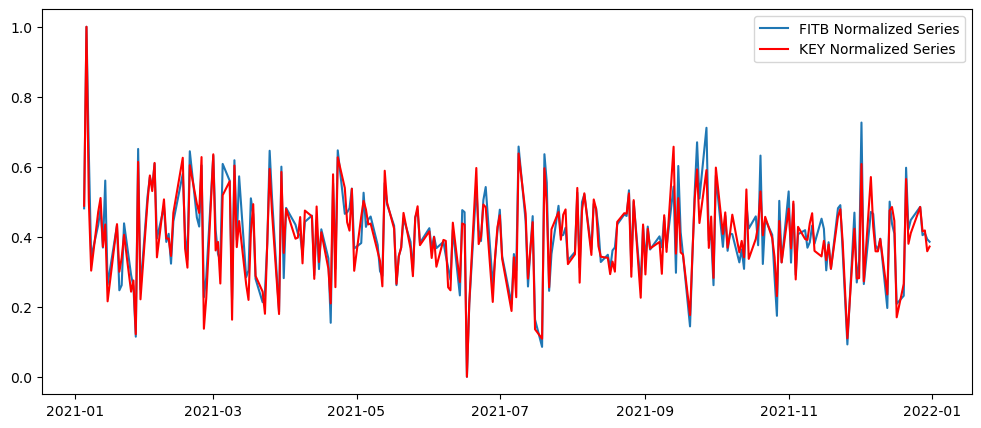

In [29]:
# Plotting the results
plt.figure(figsize=(12,5))

plt.plot(scaled_train_data['FITB'], label = 'FITB Normalized Series')
plt.plot(scaled_train_data['KEY'], label = 'KEY Normalized Series', color = 'red')

plt.legend()
plt.show()

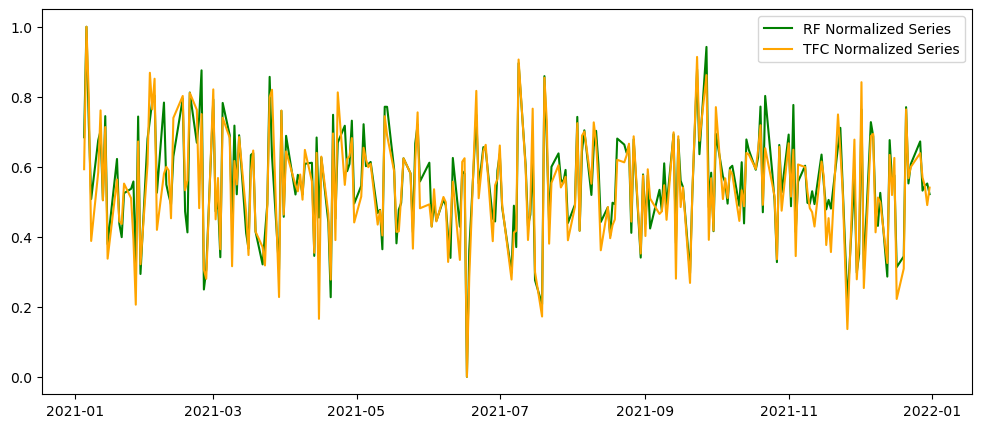

In [30]:
# Plotting the results
plt.figure(figsize=(12,5))

plt.plot(scaled_train_data['RF'], label = 'RF Normalized Series', color = 'green')
plt.plot(scaled_train_data['TFC'], label = 'TFC Normalized Series', color = 'orange')

plt.legend()
plt.show()